In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pydicom -q
!pip install monai -q
!pip install medcam -q

In [4]:
################################## IMPORTS

# Others
import os
import glob
import pydicom
import skimage
import pandas as pd
import numpy as np
from medcam import medcam
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,precision_score,f1_score, classification_report
from monai.transforms import Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom , Resize , resize_center

# Torch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import trange, tqdm
from torchvision import transforms
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader

################################## Determine device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
print(device)

cuda:0


In [5]:
################################## read_data
def read_data(path):
    All_DCM_files = dict()
    All_DCM_imgs = dict()
    IMG_PX_SIZE = 128

    for filename in tqdm(glob.iglob(path + '**/*.dcm' , recursive=True) , desc = "Reading" , ):
        patient_id = filename.split('/')[2]
        DCM_file = pydicom.dcmread(filename)
        #transfered_image = Transform(DCM_file.pixel_array)
        image = skimage.img_as_float64(DCM_file.pixel_array)
        image = resize(image, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True) #resize
        All_DCM_imgs.setdefault(patient_id , []).append(image)
    return  All_DCM_imgs
 
################################## clean_table

def clean_table(path):
    table = pd.read_csv(path)
    table.index = table['Patient Identifier']
    table = table.drop(columns = ['Patient Identifier' , 'TNM Pathology' , 'Survival Time' , 'Convexity' ,  'Entropy Ratio Score'])
    idx = []
    for element in table.index:
        new_idx = 'R_' + element.split('_')[1]
        idx.append(new_idx)
    table = table.replace('1 (ALIVE)' , 1)
    table = table.replace('0 (DEAD)' , 0)
    table.index = idx
    dic = table.to_dict()
    my_dic = dic['Vital Status']
    return my_dic



In [6]:
dataset = read_data('CT_Scan/dataset/')
table = clean_table('Table_D.csv')

In [7]:
################################## creat_dataset
def preprocess(All_DCM_imgs , table):
    dataset = []
    for patient_id in All_DCM_imgs:
        label = table[patient_id]
        images = All_DCM_imgs[patient_id]
        mid = len(images)//2
        images = images[mid - 10 : mid+10 ]         
        images = np.array(images)
        dataset.append((images , label))
    return np.array(dataset)

In [8]:
dataset = preprocess(dataset , table)

In [9]:
################################## augmentation

train_transforms = Compose([ 
    AddChannel(),          
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

def augmentation(dataset , transform):

    all = []
    print(type(dataset))
    for element in dataset:
        image = element[0]
        label = element[1]
        image = np.array(image)
        image2 = torch.Tensor(transform(image))
        if label == 0:
            image3 = torch.Tensor(transform(image))
            all.append((image3 , label))
        image =  torch.Tensor(AddChannel()(image))
        all.append((image , label))
        all.append((image2 , label))
    return all

In [10]:
kfold =KFold(n_splits = 5)

In [11]:
#agregando scores
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=2, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool3d(kernel_size=2)

        self.conv2 = nn.Conv3d(16, 32, kernel_size=2, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool3d(kernel_size=2)

        self.conv3 = nn.Conv3d(32, 64, kernel_size=2, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool3d(kernel_size=2)

        self.conv4 = nn.Conv3d(64, 128, kernel_size=2, padding=1)
        self.bn4 = nn.BatchNorm3d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool3d(kernel_size=2)   

        self.fc1 = nn.Linear(16384, 1000)
        self.fc2 = nn.Linear(1000, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax()
        
    def forward(self, x):

        out = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        out = self.pool2(self.relu2(self.bn2(self.conv2(out))))
        
        out = self.pool3(self.relu3(self.bn3(self.conv3(out))))
        out = self.pool4(self.relu4(self.bn4(self.conv4(out))))
                
        out = torch.flatten(out , start_dim=1)
        #print(out.shape)
        
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)

        out = self.softmax(out) 
        
        return out

In [31]:
def train(epochs):

    LEARNING_RATE = 5e-6
    av_acc = 0
    best_acc = 0
    for fold, (train_index, test_index) in enumerate(kfold.split(dataset)):

        train = torch.utils.data.Subset(dataset, train_index)
        test = torch.utils.data.Subset(dataset, test_index)
        
        augmented_train = augmentation(train , train_transforms)

        test_transforms =  Compose([  
            AddChannel(),         
            ScaleIntensity(),
            ToTensor()
        ])
        testi = []
        for t in test:
            im = t[0]
            l = t[1]
            im = np.array(im)

            im = torch.Tensor(test_transforms(im).float())
            testi.append((im , l))

        train_loader = torch.utils.data.DataLoader(augmented_train, batch_size=32, shuffle=True , num_workers=0 )
        test_loader = torch.utils.data.DataLoader(testi, batch_size=32, shuffle=True , num_workers= 0)
        
        model = Classifier()
        optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
        model = model.to(device)
        model.train()
         
        print('============================ fold %d =======================================' %(fold+1))
         
        ##################################### train phase
        for epoch in trange(epochs):
            train_loss = 0
            train_acc = 0
            k = 1
            for inputs , labels in train_loader:
                # clean inputs
                inputs = inputs.float().to(device)
                labels = labels.to(device)
                # learn
                optimizer.zero_grad()
                outputs= model(inputs)
                loss = F.cross_entropy(outputs, labels.long())  
                
                loss.backward()  
                
                #loss.backward()  
                optimizer.step() 

                # save loss
                train_loss += loss.item()
                # save acc
                preds = torch.max(outputs, dim=1)[1]
                train_acc += (preds == labels).float().sum()
                #print()
                #print("labels:" , labels)
                #print("preds:", preds)
            train_loss /= len(train_loader.dataset)
            train_acc/= len(train_loader.dataset)
            print('==>epoch %d/20 | Average loss: %.6f | Accuracy: %.3f' %( epoch+1 , train_loss ,train_acc ))

        
        ##################################### Test phase
        test_loss = 0
        test_acc = 0
        All_inputs = []
        All_preds = []
        All_labels = []
        for inputs , labels in test_loader:
            # clean inputs
            inputs = inputs.float().to(device)
            labels = labels.to(device)
            # learn
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels.long())  
            # save loss
            test_loss += loss.item()
            # save acc
            preds = torch.max(outputs, dim=1)[1]
            test_acc += (preds == labels).float().sum()

            # save all
            All_preds.append(preds)
            All_inputs.append(inputs)
            All_labels.append(labels)
        
        test_loss /= len(test_loader.dataset)
        test_acc /= len(test_loader.dataset)
        av_acc += test_acc

        print('==>test on fold: %d | Average loss: %.6f | Accuracy: %.3f' %(fold+1 , test_loss ,test_acc ))
        print()

        if test_acc > best_acc:
            best_model = model
            best_pred = All_preds
            best_labels = All_labels
            best_inputs = All_inputs
            best_acc = test_acc
    print()
    print(" =======> Final Acc:", av_acc/5 ) 
    return best_model , best_pred , best_inputs , best_labels
        

In [32]:
best_model , best_pred , best_inputs , best_labels = train(epochs = 20)

torch.utils.data.dataset.Subset
============================ fold 1 =======================================


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


==>epoch 1/20 | Average loss: 0.026370 | Accuracy: 0.398
==>epoch 2/20 | Average loss: 0.024401 | Accuracy: 0.602
==>epoch 3/20 | Average loss: 0.024303 | Accuracy: 0.566
==>epoch 4/20 | Average loss: 0.023131 | Accuracy: 0.611
==>epoch 5/20 | Average loss: 0.022812 | Accuracy: 0.646
==>epoch 6/20 | Average loss: 0.023024 | Accuracy: 0.655
==>epoch 7/20 | Average loss: 0.023048 | Accuracy: 0.646
==>epoch 8/20 | Average loss: 0.022608 | Accuracy: 0.611
==>epoch 9/20 | Average loss: 0.022614 | Accuracy: 0.681
==>epoch 10/20 | Average loss: 0.022009 | Accuracy: 0.646
==>epoch 11/20 | Average loss: 0.022072 | Accuracy: 0.673
==>epoch 12/20 | Average loss: 0.021246 | Accuracy: 0.717
==>epoch 13/20 | Average loss: 0.022188 | Accuracy: 0.664
==>epoch 14/20 | Average loss: 0.021580 | Accuracy: 0.690
==>epoch 15/20 | Average loss: 0.021561 | Accuracy: 0.699
==>epoch 16/20 | Average loss: 0.021223 | Accuracy: 0.717
==>epoch 17/20 | Average loss: 0.020099 | Accuracy: 0.779
==>epoch 18/20 | Averag

==>epoch 1/20 | Average loss: 0.025954 | Accuracy: 0.474
==>epoch 2/20 | Average loss: 0.025376 | Accuracy: 0.534
==>epoch 3/20 | Average loss: 0.023561 | Accuracy: 0.603
==>epoch 4/20 | Average loss: 0.023990 | Accuracy: 0.569
==>epoch 5/20 | Average loss: 0.023843 | Accuracy: 0.578
==>epoch 6/20 | Average loss: 0.023259 | Accuracy: 0.586
==>epoch 7/20 | Average loss: 0.023106 | Accuracy: 0.621
==>epoch 8/20 | Average loss: 0.022991 | Accuracy: 0.595
==>epoch 9/20 | Average loss: 0.022154 | Accuracy: 0.629
==>epoch 10/20 | Average loss: 0.022509 | Accuracy: 0.655
==>epoch 11/20 | Average loss: 0.021683 | Accuracy: 0.698
==>epoch 12/20 | Average loss: 0.021452 | Accuracy: 0.690
==>epoch 13/20 | Average loss: 0.021656 | Accuracy: 0.698
==>epoch 14/20 | Average loss: 0.021779 | Accuracy: 0.647
==>epoch 15/20 | Average loss: 0.020789 | Accuracy: 0.733
==>epoch 16/20 | Average loss: 0.020615 | Accuracy: 0.690
==>epoch 17/20 | Average loss: 0.020613 | Accuracy: 0.707
==>epoch 18/20 | Averag

==>epoch 1/20 | Average loss: 0.025555 | Accuracy: 0.491
==>epoch 2/20 | Average loss: 0.025059 | Accuracy: 0.570
==>epoch 3/20 | Average loss: 0.023410 | Accuracy: 0.588
==>epoch 4/20 | Average loss: 0.023023 | Accuracy: 0.649
==>epoch 5/20 | Average loss: 0.023158 | Accuracy: 0.605
==>epoch 6/20 | Average loss: 0.022500 | Accuracy: 0.667
==>epoch 7/20 | Average loss: 0.022636 | Accuracy: 0.614
==>epoch 8/20 | Average loss: 0.021048 | Accuracy: 0.667
==>epoch 9/20 | Average loss: 0.021485 | Accuracy: 0.702
==>epoch 10/20 | Average loss: 0.021514 | Accuracy: 0.702
==>epoch 11/20 | Average loss: 0.021275 | Accuracy: 0.693
==>epoch 12/20 | Average loss: 0.020978 | Accuracy: 0.711
==>epoch 13/20 | Average loss: 0.021551 | Accuracy: 0.667
==>epoch 14/20 | Average loss: 0.022340 | Accuracy: 0.675
==>epoch 15/20 | Average loss: 0.020370 | Accuracy: 0.763
==>epoch 16/20 | Average loss: 0.021436 | Accuracy: 0.719
==>epoch 17/20 | Average loss: 0.020566 | Accuracy: 0.728
==>epoch 18/20 | Averag

==>epoch 1/20 | Average loss: 0.023448 | Accuracy: 0.475
==>epoch 2/20 | Average loss: 0.023162 | Accuracy: 0.558
==>epoch 3/20 | Average loss: 0.022865 | Accuracy: 0.550
==>epoch 4/20 | Average loss: 0.022489 | Accuracy: 0.583
==>epoch 5/20 | Average loss: 0.022515 | Accuracy: 0.600
==>epoch 6/20 | Average loss: 0.021689 | Accuracy: 0.625
==>epoch 7/20 | Average loss: 0.021307 | Accuracy: 0.608
==>epoch 8/20 | Average loss: 0.021452 | Accuracy: 0.667
==>epoch 9/20 | Average loss: 0.021289 | Accuracy: 0.617
==>epoch 10/20 | Average loss: 0.020514 | Accuracy: 0.683
==>epoch 11/20 | Average loss: 0.020741 | Accuracy: 0.658
==>epoch 12/20 | Average loss: 0.020705 | Accuracy: 0.642
==>epoch 13/20 | Average loss: 0.019519 | Accuracy: 0.717
==>epoch 14/20 | Average loss: 0.020729 | Accuracy: 0.708
==>epoch 15/20 | Average loss: 0.020149 | Accuracy: 0.642
==>epoch 16/20 | Average loss: 0.019335 | Accuracy: 0.750
==>epoch 17/20 | Average loss: 0.019062 | Accuracy: 0.725
==>epoch 18/20 | Averag

==>epoch 1/20 | Average loss: 0.023933 | Accuracy: 0.581
==>epoch 2/20 | Average loss: 0.023342 | Accuracy: 0.556
==>epoch 3/20 | Average loss: 0.022555 | Accuracy: 0.590
==>epoch 4/20 | Average loss: 0.021649 | Accuracy: 0.667
==>epoch 5/20 | Average loss: 0.022208 | Accuracy: 0.641
==>epoch 6/20 | Average loss: 0.021873 | Accuracy: 0.641
==>epoch 7/20 | Average loss: 0.021903 | Accuracy: 0.632
==>epoch 8/20 | Average loss: 0.021316 | Accuracy: 0.667
==>epoch 9/20 | Average loss: 0.021252 | Accuracy: 0.675
==>epoch 10/20 | Average loss: 0.020926 | Accuracy: 0.692
==>epoch 11/20 | Average loss: 0.020754 | Accuracy: 0.726
==>epoch 12/20 | Average loss: 0.020430 | Accuracy: 0.709
==>epoch 13/20 | Average loss: 0.020569 | Accuracy: 0.684
==>epoch 14/20 | Average loss: 0.021103 | Accuracy: 0.718
==>epoch 15/20 | Average loss: 0.020226 | Accuracy: 0.718
==>epoch 16/20 | Average loss: 0.020584 | Accuracy: 0.709
==>epoch 17/20 | Average loss: 0.020131 | Accuracy: 0.718
==>epoch 18/20 | Averag

In [14]:
pip install captum

In [113]:
t = best_inputs[0]

In [117]:
from captum.attr import LayerGradCam

In [118]:
layer_gc = LayerGradCam(best_model, best_model.conv4)

In [119]:
c_attr = layer_gc.attribute(t, 1)

/usr/local/lib/python3.6/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [120]:
from captum.attr._utils.attribution import LayerAttribution

In [121]:
upsampled_attr = LayerAttribution.interpolate(c_attr, (20 , 128, 128))

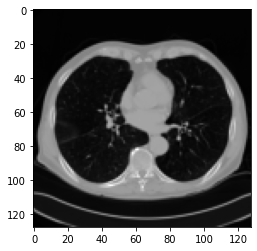

In [129]:
plt.imshow(t[12 , 0  , 0 , : , :].cpu() , cmap = 'gray')

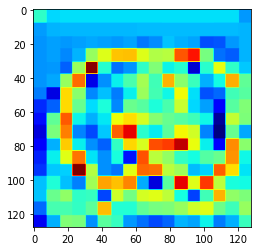

In [128]:
plt.imshow(upsampled_attr[12 , 0  , 0 , : , :].detach().cpu() , cmap = 'jet')